### Load data

(array([[[0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0]],
 
        ..., 
        [[0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0]]]), (1016,))

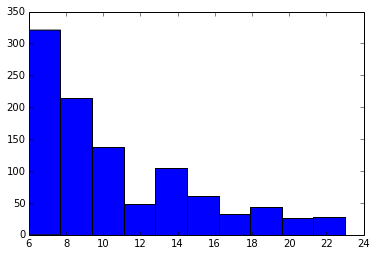

In [95]:
%matplotlib inline
import pandas as pd

data = pd.read_csv("../datasets/reddit/reddit_training.csv")
#data.sarcasm_tag = le.transform(data.sarcasm_tag)
train = data.copy()#[["body", "sarcasm_tag"]]
c = CountVectorizer()

def f(x):
    return [x_i.strip() for x_i in x.split() if len(x_i.strip()) > 0]
b = c.fit_transform(data.body)
words_frequency = b.toarray().sum(0)
log_words_frequency = np.log(words_frequency)

log_mean = log_words_frequency.mean()
log_std = log_words_frequency.std()

criteria_lower = log_words_frequency >= (log_mean - log_std)
criteria_upper = log_words_frequency <= (log_mean + 2*log_std)
criteria = (criteria_lower) & (criteria_upper) & (words_frequency > 5)
indicies = np.where(criteria)

plt.hist(words_frequency[indicies])
b.toarray()[:, indicies], words_frequency[indicies].shape

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

le = LabelEncoder()
le.fit(train.sarcasm_tag.values)
labels = le.transform(train.sarcasm_tag.values)
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=23, min_df=6)),
#    ('tfidf', TfidfVectorizer(sublinear_tf=True, max_df=0.5,
#                                 stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=50,
                                   random_state=0)),
])

scores = cross_validation.cross_val_score(pipeline, train["body"].values, 
                                          labels, 
                                          cv=5, scoring='f1')

In [100]:
import numpy as np
scores *= 100
np.mean(scores), np.std(scores)

(15.678426836321574, 10.028062133773187)

In [1]:
import sklearn

print sklearn.__version__

0.17


In [118]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.naive_bayes import MultinomialNB

class ItemSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key, array=False):
        self.key = key
        self.array = array

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        if self.array:
            return data_dict[self.key].values
        return data_dict[[self.key]].values


class ShowIntermediate(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        print(data_dict.shape)
        return data_dict

pipeline = Pipeline(
    [
        ('union', FeatureUnion(
            transformer_list=[
                ('body', Pipeline([
                    ('selector', ItemSelector(key='body', array=True)),
                    ('vect', CountVectorizer(max_df=23, min_df=6, binary=True)),
                ])),
                ('score', Pipeline([
                    ('selector', ItemSelector(key='score')),
                ]))
            ],
            transformer_weights={
                'tfidf': 2,
                'score': 1
            }
        )),
        ('clf', RandomForestClassifier(n_estimators=100,
                                   random_state=0))
    ]

)

scores = cross_validation.cross_val_score(pipeline, train, 
                                          labels, 
                                          cv=5, scoring='f1')

In [117]:
import numpy as np
scores *= 100
np.mean(scores), np.std(scores)

(16.327065723650168, 8.6614636943758754)